In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import math

TODO: INTRO

In [2]:
file_path = './Speed_Dating_Data.csv' 
    
df = pd.read_csv(file_path,error_bad_lines=False)
df.iid = df.iid.astype(float)
df.pid = df.pid.astype(float)

df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1.0,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


TODO: explain how we make these numbers

In [3]:
# This code assigns every unique person (by their iid) an attractiveness score
# based on the average of what their partners rated them
iids = pd.unique(df.iid)

personToAttractiveness = {}

rowsWithRatings = df[df.attr_o.notna()]
for subjectOfInterest in iids:
    attractiveness = statistics.mean(rowsWithRatings[rowsWithRatings.iid == subjectOfInterest].attr_o)
    personToAttractiveness[subjectOfInterest] = attractiveness

In [4]:
# Constructs a dictionary of pairs (tuple of iid and pid) to whether they matched
pairToDidMatch = {}

rowsWithPairs = df[df.iid.notna() & df.pid.notna()]

for iid in iids:
    for pid in rowsWithPairs[rowsWithPairs.iid == iid].pid:
        if (pid, iid) in pairToDidMatch:
            # Asserts that if person A matches with person B, then person B has also matched with person A
            assert rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match == pairToDidMatch[(pid, iid)]
            continue
        pairToDidMatch[(iid, pid)] = rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match

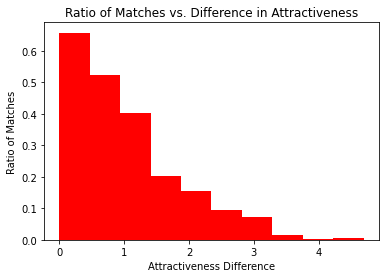

In [5]:
attractivenessDifferences = [abs(personToAttractiveness[pair[0]] - personToAttractiveness[pair[1]]) for pair in pairToDidMatch.keys()]
correspondingDidMatch = list(pairToDidMatch.values())

# Gets the attractivness difference of people who matched
attractivenessDifferencesOfMatchers = []
for i in range(len(correspondingDidMatch)):
    if correspondingDidMatch[i] == 0:
        continue
    attractivenessDifferencesOfMatchers.append(attractivenessDifferences[i])

# Plots a density histogram of people who matched where the bins are of their attractiveness difference
plt.figure()
plt.hist(attractivenessDifferencesOfMatchers, density=True, color="red") # red color for color of love
plt.title("Ratio of Matches vs. Difference in Attractiveness")
plt.xlabel("Attractiveness Difference")
plt.ylabel("Ratio of Matches")
plt.show()

TODO: explain below is absolute attractiveness vs. match success rate

In [6]:
attractivenesses = list(personToAttractiveness.values())
correspondingMatchRate = []

for subjectOfInterest in iids:
    rowsOfPerson = df[(df.iid == subjectOfInterest) & (df.pid.notna())]
    matchSuccessRate = len(rowsOfPerson[rowsOfPerson.match == 1]) / len(rowsOfPerson)
    correspondingMatchRate.append(matchSuccessRate)

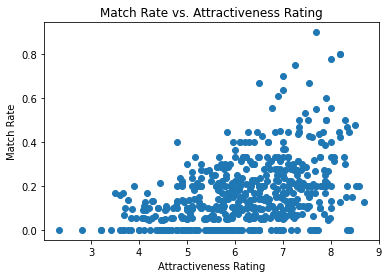

In [7]:
plt.figure()
plt.plot(attractivenesses, correspondingMatchRate, 'o')
plt.title("Match Rate vs. Attractiveness Rating")
plt.xlabel("Attractiveness Rating")
plt.ylabel("Match Rate")
plt.show()